## Importing Essential Packages

In [1]:
!pip install wordcloud

In [2]:
import os
import pandas as pd
import numpy as np
import re
import string 

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
from wordcloud import WordCloud

from kaggle.api.kaggle_api_extended import KaggleApi

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler

import warnings
warnings.filterwarnings('ignore')

## Loading dataset

In [3]:
# Set up Kaggle API credentials
os.environ['KAGGLE_CONFIG_DIR'] = os.path.expanduser('~/.kaggle')

# Initialize the Kaggle API
api = KaggleApi()
api.authenticate()

# Download the dataset
dataset_url = 'ashishkumarak/netflix-reviews-playstore-daily-updated'
api.dataset_download_files(dataset_url, path='netflix_reviews', unzip=True)

Dataset URL: https://www.kaggle.com/datasets/ashishkumarak/netflix-reviews-playstore-daily-updated


In [4]:
# List the contents of the directory
files = os.listdir('netflix_reviews')
print(files)

['netflix_reviews.csv']


In [5]:
df = pd.read_csv('netflix_reviews/netflix_reviews.csv')

In [6]:
df.head(2)

,reviewId,userName,content,score,thumbsUpCount,reviewCreatedVersion,at,appVersion
0,7dfb1f90-f185-4e81-a97f-d38f0128e5a4,Maxwell Ntloko,Good,5,1,NaN,2024-06-26 15:38:06,NaN
1,3009acc4-8554-41cf-88de-cc5e2f6e45b2,Dilhani Mahanama,👍👍,5,0,NaN,2024-06-24 15:29:54,NaN


## EDA: Exploratory Data Analysis


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113609 entries, 0 to 113608
Data columns (total 8 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   reviewId              113609 non-null  object
 1   userName              113607 non-null  object
 2   content               113607 non-null  object
 3   score                 113609 non-null  int64 
 4   thumbsUpCount         113609 non-null  int64 
 5   reviewCreatedVersion  96971 non-null   object
 6   at                    113609 non-null  object
 7   appVersion            96971 non-null   object
dtypes: int64(2), object(6)
memory usage: 6.9+ MB


## Missing Values

In [8]:
df.isnull().sum()

reviewId                    0
userName                    2
content                     2
score                       0
thumbsUpCount               0
reviewCreatedVersion    16638
at                          0
appVersion              16638
dtype: int64

In [9]:
np.where(df['userName'].isnull())

(array([  422, 15164], dtype=int64),)

In [10]:
df.iloc[422]

reviewId                             fc0ad6f5-1661-403f-82cd-86ef6acf2b40
userName                                                              NaN
content                 Very upset with the show storybook time. I was...
score                                                                   1
thumbsUpCount                                                           0
reviewCreatedVersion                                8.112.1 build 6 50665
at                                                    2024-06-15 17:01:43
appVersion                                          8.112.1 build 6 50665
Name: 422, dtype: object

In [11]:
# Identify NaN values in userName column
nan_indices = df[df['userName'].isna()].index

# Generate "user n" for each NaN value
for i, index in enumerate(nan_indices):
    df.at[index, 'userName'] = f'user {i + 1}'

In [12]:
df['content'] = df['content'].fillna('no comment')

df.drop(columns=['reviewCreatedVersion'], inplace=True)

df['appVersion'].fillna('', inplace=True)

## Visualisation 

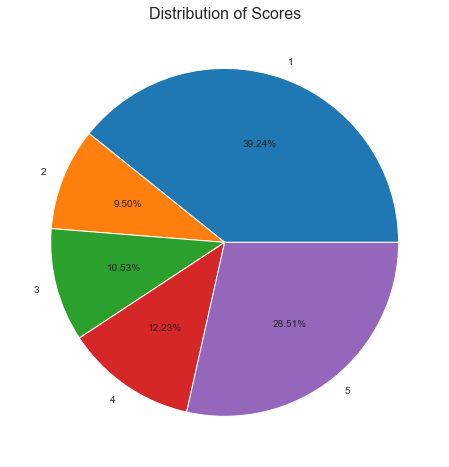

In [13]:
scores = df['score'].value_counts().sort_index()
plt.figure(figsize=(8, 8))
plt.pie(scores, labels=scores.index, autopct="%1.2f%%")
plt.title('Distribution of Scores', fontsize=16)
plt.show()

In [14]:
type(df['at'].iloc[0])

str

In [15]:
df['at'] = pd.to_datetime(df['at'])
df['Year'] = df['at'].apply(lambda time: time.year)
df['Hour'] = df['at'].apply(lambda time: time.hour)
df['Month'] = df['at'].apply(lambda time: time.month)
df['Day of Week'] = df['at'].apply(lambda time: time.dayofweek)

In [16]:
dmap = {0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri',5:'Sat',6:'Sun'}
df['Day of Week'] = df['Day of Week'].map(dmap)

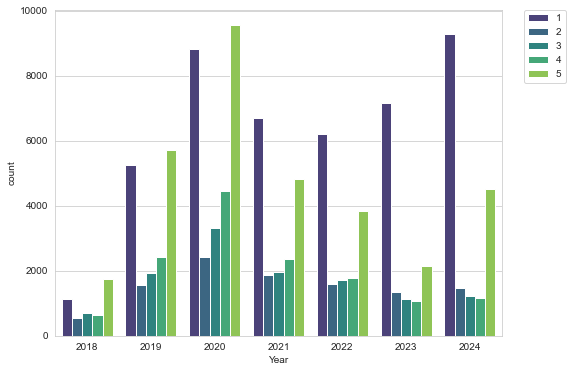

In [18]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Year',data=df,hue='score',palette='viridis')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

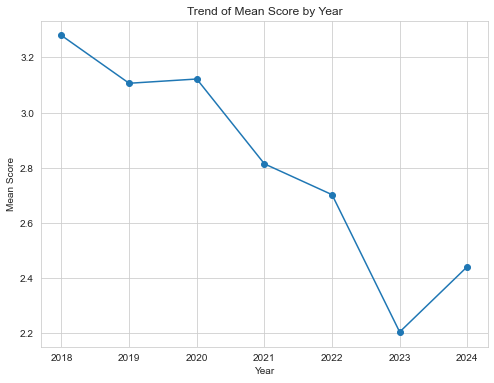

Year
2018    3.279259
2019    3.105990
2020    3.121425
2021    2.813948
2022    2.702149
2023    2.204466
2024    2.441340
Name: score, dtype: float64


In [19]:
yearly_mean_score = df.groupby('Year').mean()['score']

# Plot the trend
plt.figure(figsize=(8, 6))
yearly_mean_score.plot(kind='line', marker='o')
plt.title('Trend of Mean Score by Year')
plt.xlabel('Year')
plt.ylabel('Mean Score')
plt.grid(True)
plt.show()

print(yearly_mean_score)

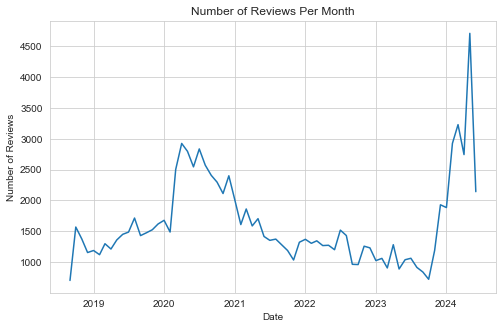

In [20]:
df['Date'] = df['at'].apply(lambda t: t.replace(day=1).date())

plt.figure(figsize=(8, 5))
df.groupby('Date').count()['content'].plot()
plt.title('Number of Reviews Per Month')
plt.xlabel('Date')
plt.ylabel('Number of Reviews')
plt.show()

In [21]:
print("Earliest Review date:", df['at'].min())
print("Latest Review date:", df['at'].max())

Earliest Review date: 2018-09-12 07:22:12
Latest Review date: 2024-06-26 15:38:06


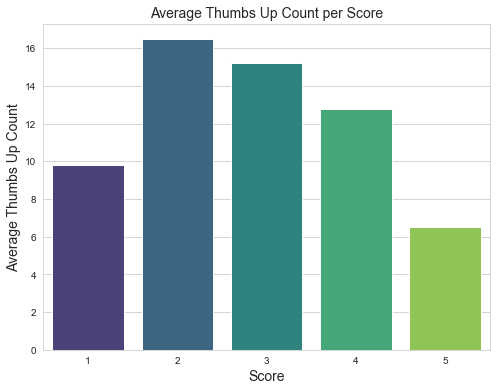

In [22]:
avg_thumbs_up = df.groupby('score')['thumbsUpCount'].mean().reset_index()
plt.figure(figsize=(8, 6))
sns.barplot(x='score', y='thumbsUpCount', data=avg_thumbs_up, palette="viridis")
plt.title('Average Thumbs Up Count per Score', fontsize=14)
plt.xlabel('Score', fontsize=14)
plt.ylabel('Average Thumbs Up Count', fontsize=14)
plt.show()

In [25]:
top_reviews = df.nlargest(10, 'thumbsUpCount')
print(top_reviews[['content', 'thumbsUpCount', "score"]])

                                                 content  thumbsUpCount  score
19493  Wow! To be able to have Netflix on my phone is...           8032      5
17108  Watching NETFLIX right now, it always updates ...           7052      5
10117  Netflix has plenty of great shows and movies t...           6990      3
10497  My only complaints are that there aren't enoug...           6558      4
1100   Netflix is just awesome. I mean who wouldn't t...           4502      4
10452  I've been using this app for years but lately,...           4369      2
11906  why do the subtitles automatically come on, wh...           4070      4
10097  I really love the app! There are a lot of good...           3935      4
10297  Love Netflix and the ability to stream on my p...           3639      2
10105  The minute I switched the service to include a...           3502      1


In [26]:
df["content"].iloc[19493]

'Wow! To be able to have Netflix on my phone is an absolute life-saver! Not only can I download my favourite TV shows and movies and be able to watch them any where at anytime (with or without Wi-Fi) theres also so much content to choose from (some a little too much content to choose from 😂). Really happy with it and looking forward to stranger things s4?'

In [27]:
count_less_than_100 = df[df['thumbsUpCount'] < 100]['thumbsUpCount'].value_counts().sum()

print("Number of value counts less than 100:", count_less_than_100)

Number of value counts less than 100: 111561


### Text Analysing

In [28]:
df['length'] = df['content'].apply(len)

,reviewId,userName,content,score,thumbsUpCount,at,appVersion,Year,Hour,Month,Day of Week,Date,length
0,7dfb1f90-f185-4e81-a97f-d38f0128e5a4,Maxwell Ntloko,Good,5,1,2024-06-26 15:38:06,,2024,15,6,Wed,2024-06-01,4
1,3009acc4-8554-41cf-88de-cc5e2f6e45b2,Dilhani Mahanama,👍👍,5,0,2024-06-24 15:29:54,,2024,15,6,Mon,2024-06-01,2


In [29]:
df.length.describe()

count    113609.000000
mean        157.358977
std         111.988258
min           1.000000
25%          84.000000
50%         124.000000
75%         195.000000
max        1752.000000
Name: length, dtype: float64

In [30]:
df[df['length'] == 1752]['content'].iloc[0]

"The app is mostly great,however I have a problem. I watch a certain series composed of 8 seasons. The last season has premiered on December 14th 2018 I believe, so it is far from being new. The problem here is that basicaly everywhere that I have searched it seems to say that Netflix has all 8 seasons. However, on my account it only shows two seasons of whic I have already watched all of the episodes. I have tried looking everywhere around Netflix to see if I can somehow watch the remaining 6 seasons, but I can't seem to find them anywhere. And I don't want to be forced to spend even more money to watch the seasons streaming somewhere, even tho they currently don't stream anywhere. This show was the whole reason I bought Netflix for, and as of right now, I am starting to have certain doubts about whether I made the right choice spending my money on this app. Please fix this mistake here, because I can't watch this anywhere else other than Netflix and I have tried and waited for too lo

In [31]:
df[df['length'] == 1]['content'].iloc[0]

'😓'

array([[<AxesSubplot:title={'center':'1'}>,
        <AxesSubplot:title={'center':'2'}>],
       [<AxesSubplot:title={'center':'3'}>,
        <AxesSubplot:title={'center':'4'}>],
       [<AxesSubplot:title={'center':'5'}>, <AxesSubplot:>]], dtype=object)

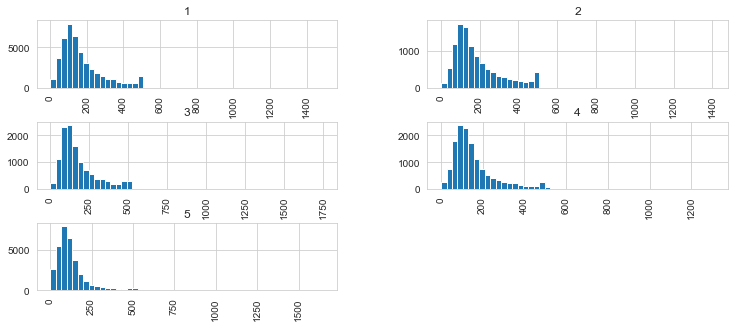

In [32]:
df.hist(column='length', by='score', bins=50,figsize=(12,5))

## Pre-processing

In [33]:
def remove_emoji(data):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0" u"\U00002702-\U000027B0" u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937" u"\U00010000-\U0010ffff" u"\u2640-\u2642" 
        u"\u2600-\u2B55" u"\u200d" u"\u23cf" u"\u23e9" u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030" "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',data) 

In [34]:
df['clean_comments'] = df['content'].str.replace('\d+', '') #removing numbers
df['clean_comments'] = df['clean_comments'].str.lower() #lower case
df['clean_comments'] = df.clean_comments.str.replace('@[\w\-]+', '', regex = True) #removing mentions
df['clean_comments'] = df['clean_comments'].apply(lambda x:re.sub(r"http\S+", "", x))   #removing links
df['clean_comments'] = df.clean_comments.apply(lambda x:remove_emoji(x))    #removing emoji
df['clean_comments'] = df['clean_comments'].str.replace('[{}]'.format(string.punctuation), '') #removing punctuations

In [35]:
lemmatizer = WordNetLemmatizer()
sb = SnowballStemmer("english")

df["clean_comments"] = [' '.join(lemmatizer.lemmatize(word) for word in comment.split()) for comment in df["clean_comments"]]
df["clean_comments"] = [' '.join(sb.stem(word) for word in comment.split()) for comment in df["clean_comments"]]

In [36]:
stop_words = set(stopwords.words('english'))
stop_words.add('netflix')

df['clean_comments'] = df['clean_comments'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

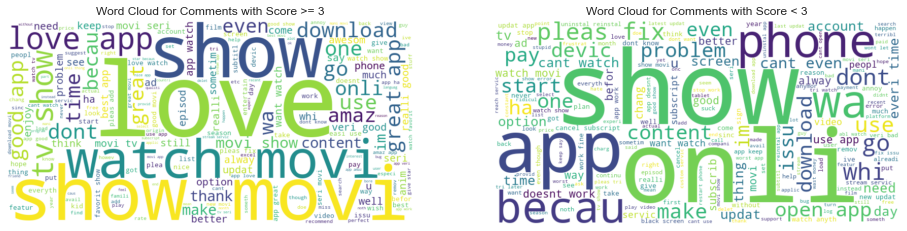

In [37]:
# Separate the comments based on the score
positive_comments = df[df['score'] >= 3]['clean_comments'].dropna()
negative_comments = df[df['score'] < 3]['clean_comments'].dropna()

# Join the comments into single strings
positive_text = " ".join(comment for comment in positive_comments)
negative_text = " ".join(comment for comment in negative_comments)

# Generate word clouds
positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
negative_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_text)

# Plot the word clouds
plt.figure(figsize=(16,10))

# Plot positive comments word cloud
plt.subplot(1, 2, 1)
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Comments with Score >= 3')
plt.axis('off')

# Plot negative comments word cloud
plt.subplot(1, 2, 2)
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Comments with Score < 3')
plt.axis('off')

plt.show()

## TF-IDF

In [39]:
vectorizer = TfidfVectorizer(max_features=200)
tfidf_matrix = vectorizer.fit_transform(df['clean_comments'])
tfidf_scores = tfidf_matrix.toarray()


#text_vector = vectorizer.fit_transform(df['clean_comments']).toarray()
feature_names = vectorizer.get_feature_names_out()

## Similarity

### Correlation

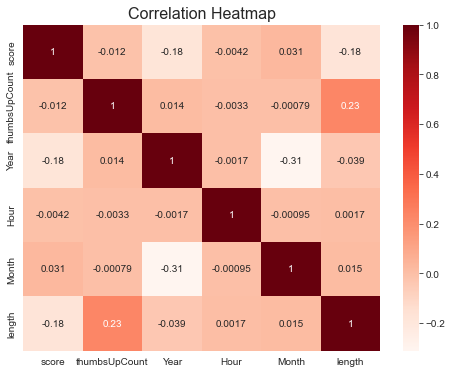

In [40]:
# Drop non-numeric columns
numeric_df = df.select_dtypes(include=['int64', 'float64'])

plt.figure(figsize=(8, 6))
sns.heatmap(numeric_df.corr(), annot=True, cmap='Reds')
plt.title('Correlation Heatmap', fontsize=16)
plt.show()

### Cosine similarity

In [41]:
from sklearn.model_selection import train_test_split

X = df['clean_comments']
y = df['score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10)

In [42]:
# Concatenate X_train and y_train into a DataFrame
df_test = pd.concat([X_test, y_test], axis=1).reset_index()

In [43]:
scaler = MinMaxScaler()
df_test['score'] = scaler.fit_transform(df_test[['score']])

# Encode categorical data
encoder = OneHotEncoder()
encoded_comments = encoder.fit_transform(df_test[['clean_comments']]).toarray()

# Combine encoded comments with the normalized scores
# Expand the scores to 2D to concatenate with encoded comments
scores_2d = df_test[['score']].values
combined = np.hstack((encoded_comments, scores_2d))

# Calculate similarity
similarity_matrix = cosine_similarity(combined)
similarity_df = pd.DataFrame(similarity_matrix, index=df_test['clean_comments'], columns=df_test['clean_comments'])

In [44]:
similarity_df.head(5)

clean_comments,great app bug watch screen black onli audio,whi cant uninstal dont want phone dont account becaus im broke whi keep app phone wont let uninstal,new updat wa suck cant chang bright minimum alway bright,cant even stream full hd quadhd displayultra hd plan take high fee veri poor develop team rather intent whatev watch phone even ultra hd plan stuck sd qualiti pathet,yes part sometim seem lose view histori present incorrect view posit show film,expens offer like yet point must time,chill help lot surviv dure lockdown thank,run stream kid show complic child chang show someth schedul seri show everyday like tv show,work devic hulu work devic hulu suck,love choic show movi easi use ui,...,cant cast adsupport plan whose bright idea wa app useless alon keep ever consid upgrad plan higher tier whose bright idea wa includ ad anyway wasnt origin main draw wa ad free veri scummi behaviour cring,fyi chang wifi ani reason freez everyth got rid back becaus jump hoop watch show got stupid also onli data bit keep tri get set wifi sorri live far get ani right,far wa good video isnt work onli voic audibl latest updat bluetooth headphon work watch movi,last updat screen share onli ha sound go fix po app cannot cast tv set,person like easi use like download thing watch offlin,movi avail particular region sometim go websit purchas softewar watch seri anim,good app thing concern im tri watch first want go electron see netflex momdadyoung sisterand iwe phonestvsand sister laptop well howev also desktop comput gest room reason netflex desktop stope work reason love netflex could fix littl problem recommend app,fact cant delet app phone high annoy whi need imped phone inform still password share whatev call reason cancel pay servic im go watch household dare tell cant watch also tire see liter bollywood home page algorithm good tire trash movi long time star,playback better stream app sinc past coupl updat extrem buggi cast chromecast constant restart abl use playback control even volum stop work everytim screen turn restart app sometim doesnt even work pleas fix ill chang star rate,new updat fix soundbar issu yay star instead minus star becaus parent rate need adjust minus anoth star becaus expens
clean_comments,,,,,,,,,,,,,,,,,,,,,
great app bug watch screen black onli audio,1.000000,0.0,0.108465,0.0,0.268328,0.108465,0.316228,0.316228,0.316228,0.316228,...,0.0,0.0,0.0,0.0,0.268328,0.268328,0.268328,0.0,0.200000,0.200000
whi cant uninstal dont want phone dont account becaus im broke whi keep app phone wont let uninstal,0.000000,1.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
new updat wa suck cant chang bright minimum alway bright,0.108465,0.0,1.000000,0.0,0.145521,0.058824,0.171499,0.171499,0.171499,0.171499,...,0.0,0.0,0.0,0.0,0.145521,0.145521,0.145521,0.0,0.108465,0.108465
cant even stream full hd quadhd displayultra hd plan take high fee veri poor develop team rather intent whatev watch phone even ultra hd plan stuck sd qualiti pathet,0.000000,0.0,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
yes part sometim seem lose view histori present incorrect view posit show film,0.268328,0.0,0.145521,0.0,1.000000,0.145521,0.424264,0.424264,0.424264,0.424264,...,0.0,0.0,0.0,0.0,0.360000,0.360000,0.360000,0.0,0.268328,0.268328


# Recommendation System

In [45]:
len(df["userName"].unique())

80504

In [46]:
113609 - 80504

33105

In [47]:
# Identify usernames that appear more than once
user_counts = df['userName'].value_counts()
repeated_users = user_counts[user_counts > 1].index

# Filter the DataFrame
filtered_df = df[df['userName'].isin(repeated_users)]

mask = filtered_df['userName'] != "A Google user"
filtered_df = filtered_df[mask].reset_index()
filtered_df = filtered_df.drop(["index"], axis=1)

In [48]:
filtered_df["userName"].value_counts()

Alex               21
Josh               17
J                  15
Michael            14
Ryan               13
                   ..
Muhammad Qasim      2
Kriti               2
Philip Young        2
Sinjin Rancourt     2
Aftab Alam          2
Name: userName, Length: 1892, dtype: int64

In [49]:
categorical_features = ['appVersion', 'Day of Week', 'clean_comments']
numeric_features = ['thumbsUpCount', 'Year', 'Hour', 'Month', 'length']

# One-hot encode categorical features
encoder = OneHotEncoder(sparse=False)
encoded_categorical = encoder.fit_transform(filtered_df[categorical_features])

# Normalize numeric features
scaler = StandardScaler()
scaled_numeric = scaler.fit_transform(filtered_df[numeric_features])

# Combine processed features
processed_features = np.hstack([encoded_categorical, scaled_numeric])

# Calculate cosine similarity matrix
cosine_sim_matrix = cosine_similarity(processed_features)

# Create a DataFrame for similarity matrix
sim_df = pd.DataFrame(cosine_sim_matrix, index=filtered_df.index, columns=filtered_df.index)

In [51]:
df_with_nan = filtered_df.copy()

num_rows = filtered_df.shape[0]
num_to_nan = int(0.2 * num_rows)

# Generate random indices to set values to NaN
indices_to_nan = np.random.choice(df_with_nan.index, num_to_nan, replace=False)

# Set values at these indices to NaN
df_with_nan.loc[indices_to_nan, 'score'] = np.nan

In [52]:
def recommend_score(user_index):
    user_scores = df_with_nan['score']
    similar_users = sim_df.loc[user_index].drop(user_index)
    similar_users_scores = user_scores.drop(user_index)
    
    # Filter out users with missing scores from similar users
    valid_similar_users = similar_users[~similar_users_scores.isna()]
    valid_similar_users_scores = similar_users_scores[~similar_users_scores.isna()]

    # Select top 3 similar users
    top_similar_users = valid_similar_users.nlargest(10)
    top_similar_users_scores = valid_similar_users_scores[top_similar_users.index]
    
    recommended_score = top_similar_users_scores.mean()
    return recommended_score

# Fill in missing scores
for index, row in df_with_nan.iterrows():
    if pd.isna(row['score']):
        recommended_score = recommend_score(index)
        if not pd.isna(recommended_score):
            df_with_nan.at[index, 'score'] = recommended_score

## Evaluation

In [54]:
df_with_nan = df_with_nan.rename(columns={'score': 'recommended score'})
df_evaluation = pd.concat([filtered_df[["userName", "content", "score"]], df_with_nan[["recommended score"]]], axis=1)
# Filter rows where score is not equal to recommended score
df_evaluation = df_evaluation[df_evaluation["score"] != df_evaluation["recommended score"]]

In [55]:
df_evaluation['squared_error'] = (df_evaluation['recommended score'] - df_evaluation['score']) ** 2
df_evaluation["RMSE"] = np.sqrt(df_evaluation['squared_error'])
rmse = np.sqrt(df_evaluation['squared_error'].mean())

print(f"RMSE: {rmse}")

RMSE: 1.6450344008167177
